# IA - A2023 - PIA - Convolutional Neural Network Training
## Team Members
* 1954129 Angel Orlando Campa Torres
* 2077598 Frida Elisa Flores Mora
* 1963832 Mara Yisei López Carmona
* 1809944 Jorge Nárvaez Montemayor

## Importing packages


In [ ]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow.data import Dataset
import tensorflow.io as tfio
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [ ]:
print(os.listdir('/kaggle/input/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDataset'))

['ModerateDemented', 'NonDemented', 'VeryMildDemented', 'MildDemented']


## Reading the data

In [ ]:
def getData(path):
    imagesFolders = os.listdir(path)
    dataPaths = []
    for idx, label in enumerate(imagesFolders):
        dataRelativePath = os.path.join(path, label)
        tempDataset = Dataset.list_files(dataRelativePath + '/*.jpg', shuffle=False, seed=1234)
        labels = Dataset.from_tensor_slices([idx]).repeat(len(tempDataset))
        if idx == 0:
            dataPaths = Dataset.zip((tempDataset, labels))
        else:
            dataPaths = dataPaths.concatenate(Dataset.zip((tempDataset, labels)))
    return imagesFolders, dataPaths

In [ ]:
labelsOrder, data = getData('/kaggle/input/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDataset')

In [ ]:
labelsOrder

['ModerateDemented', 'NonDemented', 'VeryMildDemented', 'MildDemented']

In [ ]:
len(data)

33984

In [ ]:
data.shuffle(10000).as_numpy_iterator().next()

(b'/kaggle/input/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDataset/ModerateDemented/60c0be5e-15e8-4c45-be2d-bb200f8a75aa.jpg',
 0)

## Exploring the dataset

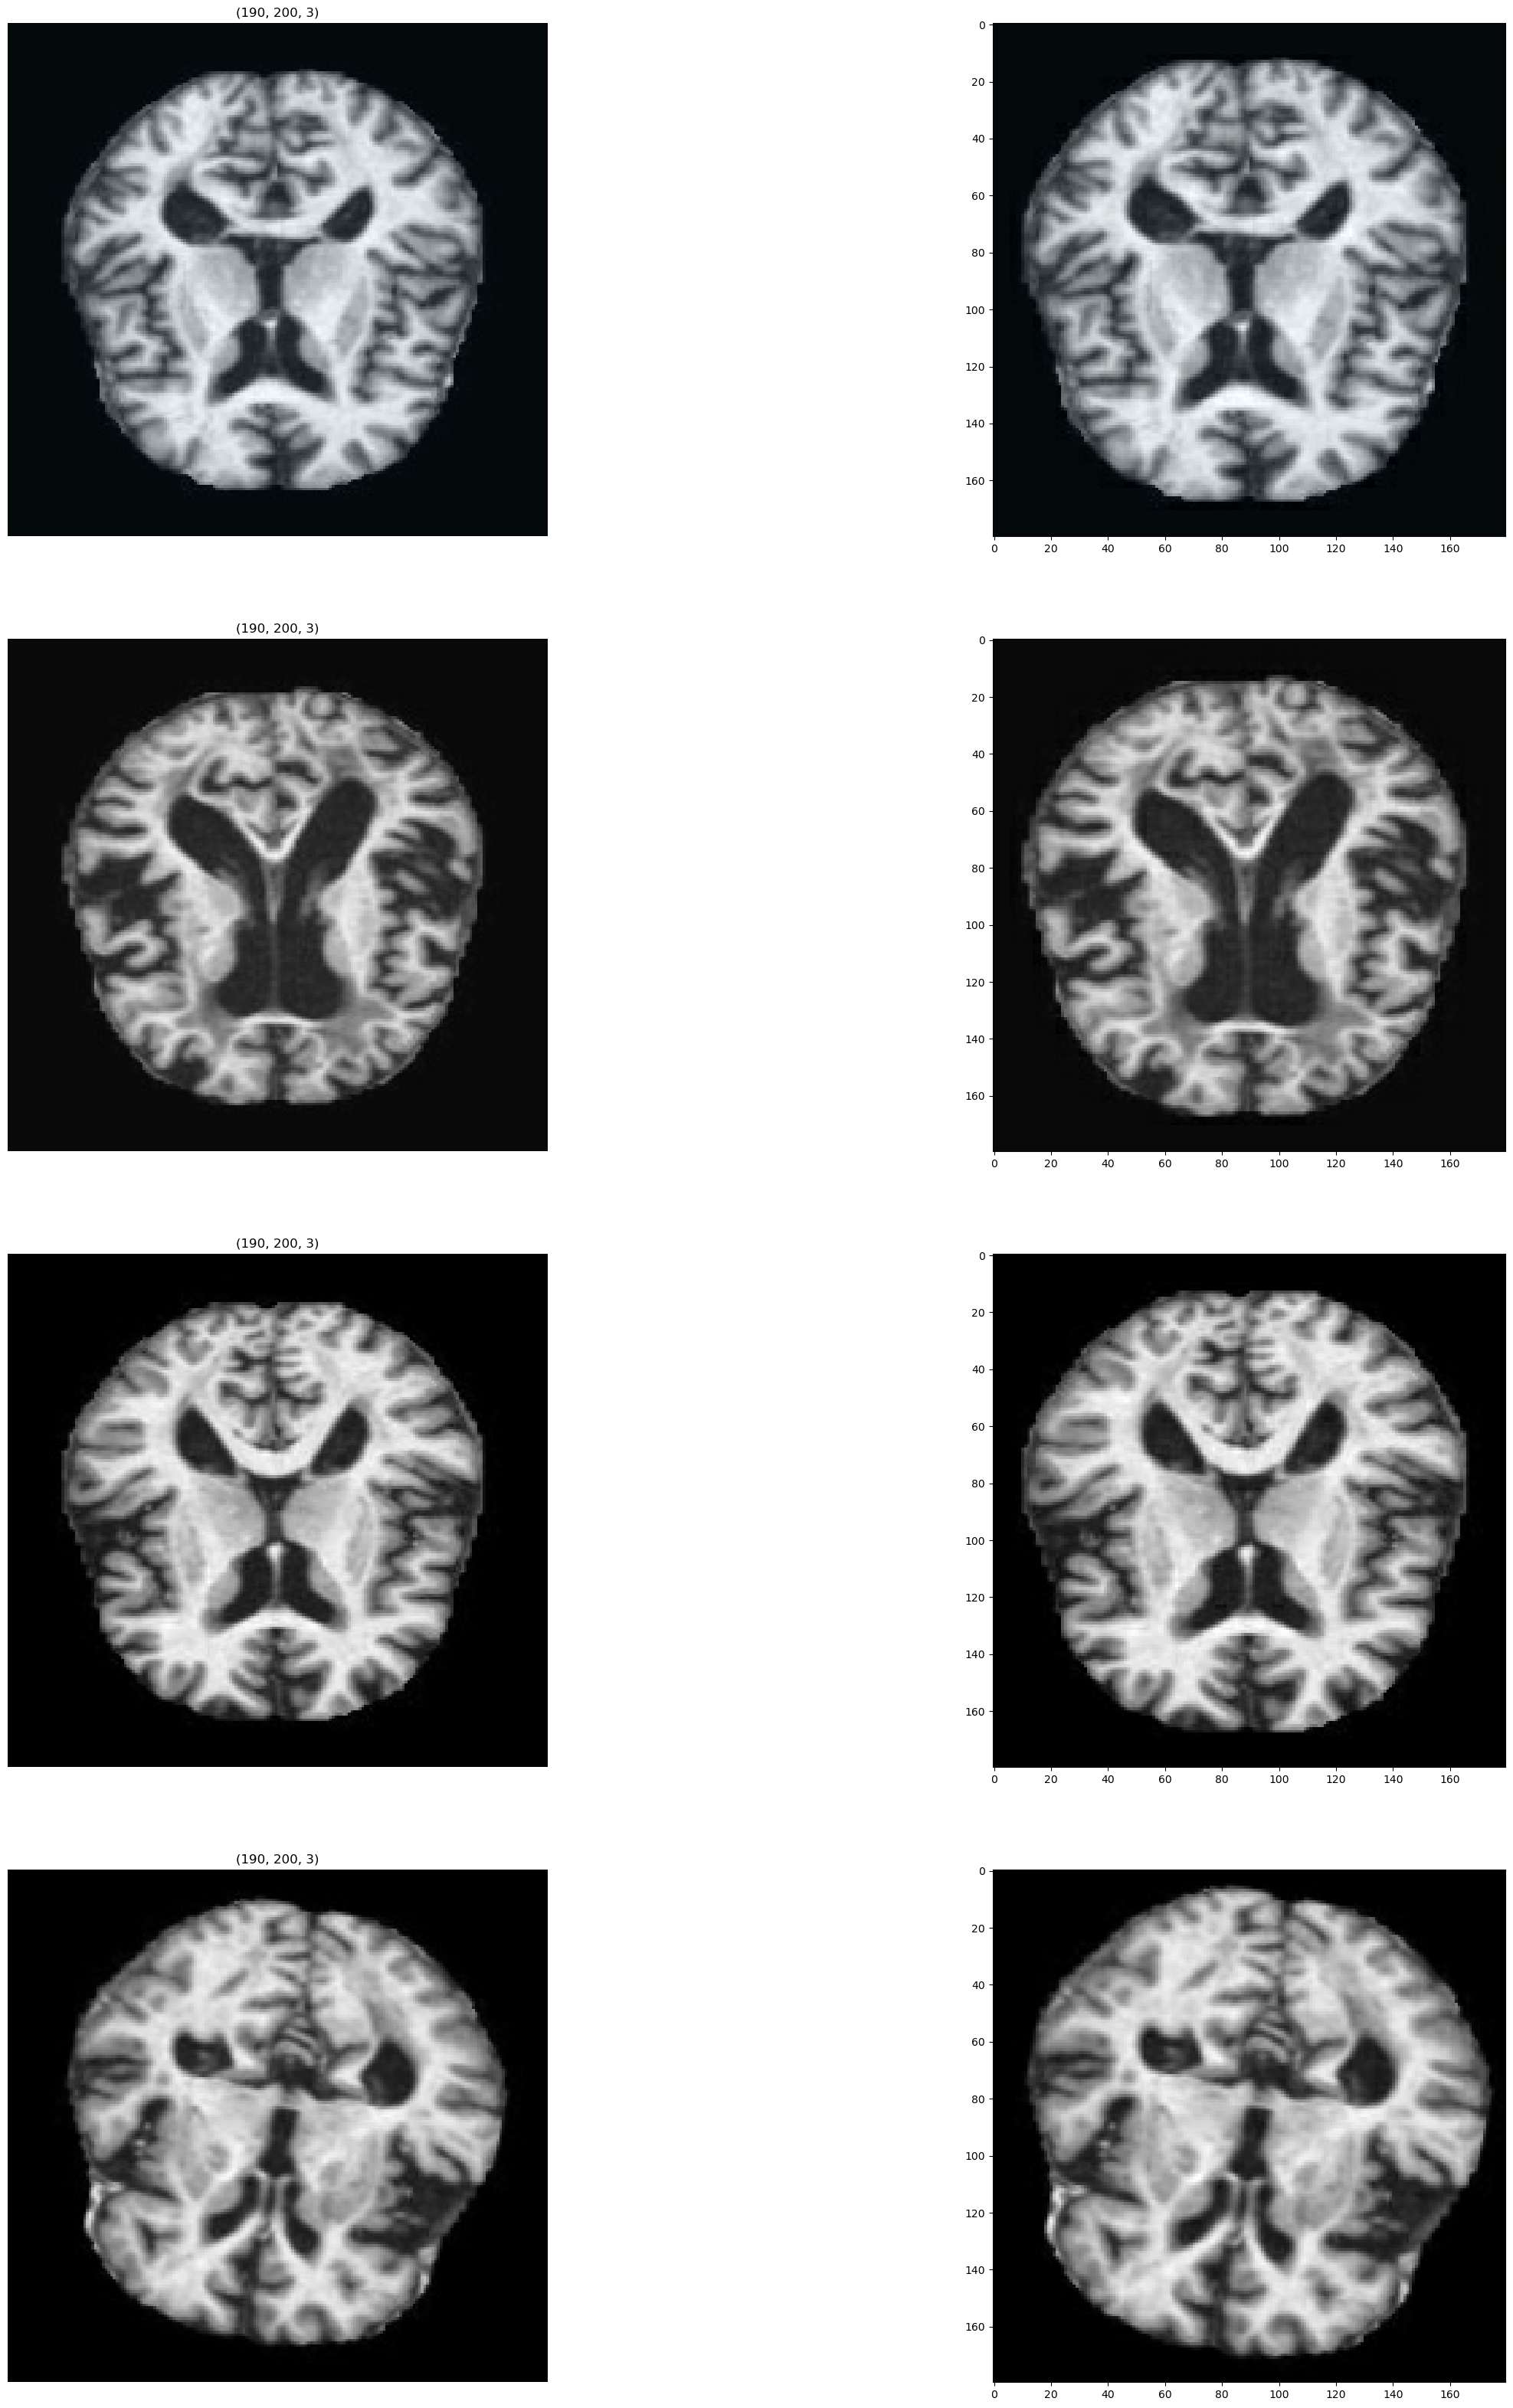

In [ ]:
plt.figure(figsize=(30,40))
layer = tf.keras.layers.CenterCrop(180, 180)
for i in range(4):
    x = data.shuffle(100000).as_numpy_iterator().next()
    u = np.asarray(tf.keras.preprocessing.image.load_img(x[0]))

    plt.subplot(4, 2, 2 * i + 1)
    plt.imshow(u)
    plt.title(u.shape)
    plt.axis('off')

    plt.subplot(4, 2, 2 * i + 2)
    plt.imshow(tf.cast(layer(tfio.decode_image(tfio.read_file(x[0]))), dtype=tf.uint8))

## Preprocessing function
1. Reading the image
2. Decoding the image
3. Converting the image to grayscale
4. Cropping from the center of the image
5. Value normalization

In [ ]:
def preprocess(imagePath, label):
    image = tfio.read_file(imagePath)
    image = tfio.decode_image(image)
    image = tf.image.rgb_to_grayscale(image)
    layer = tf.keras.layers.CenterCrop(180, 180)
    image=layer(image) / 255.0
    return image, label

In [ ]:
_ = preprocess(*(data.as_numpy_iterator().next()))
_[0].shape

TensorShape([180, 180, 1])

## Dataset pipeline

In [ ]:
def datasetConfiguration(dataset, preprocessFunction=preprocess):
    dataset = dataset.map(preprocessFunction,
                         num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.cache()
    dataset = dataset.shuffle(buffer_size=len(dataset) + 1)
    dataset = dataset.batch(16)
    dataset = dataset.prefetch(8)
    return dataset

## Dataset partition

In [ ]:
def datasetPartition(dataset):
    trainingBatches = len(dataset) * 7 //10
    testBatches = len(dataset) - trainingBatches
    train = dataset.take(trainingBatches)
    test = dataset.skip(trainingBatches).take(testBatches)
    return train, test

In [ ]:
data = datasetConfiguration(data)

In [ ]:
train, test = datasetPartition(data)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, SeparableConv2D, MaxPool2D, Dense, BatchNormalization, Conv2D, Dropout, GlobalMaxPool2D

## Model design

In [ ]:
def createModel():
    model = Sequential(name="sequentialKA")
    model.add(InputLayer((180, 180, 1)))
    model.add(Conv2D(32, (3,3), activation='relu'))
    model.add(MaxPool2D(2,2))
    model.add(Dropout(0.2))

    model.add(SeparableConv2D(64, 3, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2)))
    model.add(Dropout(0.2))

    model.add(SeparableConv2D(128, 5, activation='relu'))
    model.add(MaxPool2D((2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(SeparableConv2D(128, 5, activation='relu'))
    model.add(MaxPool2D((2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(SeparableConv2D(256, 5, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(GlobalMaxPool2D())
    model.add(Dense(128,activation='elu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='elu'))
    model.add(Dropout(0.2))
    model.add(Dense(4, activation='softmax'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
    return model
model9 = createModel()
model9.summary()

Model: "sequentialKA"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 178, 178, 32)      320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 89, 89, 32)        0         
                                                                 
 separable_conv2d_4 (Separab  (None, 87, 87, 64)       2400      
 leConv2D)                                                       
                                                                 
 batch_normalization_5 (Batc  (None, 87, 87, 64)       256       
 hNormalization)                                                 
                                                      

## Defining the callbacks

In [ ]:
def scheduler(epoch, lr):
    if lr <= 0.000001:
        return lr
    if epoch % 5 == 0 and epoch > 1:
        return lr * 0.8
    return lr

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=2, min_lr=0.000001, verbose=1)
schedule_lr = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=0)
early_s = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=1)

## First 15 epochs

In [ ]:
history9_1 = model9.fit(train, epochs=15, validation_data=test, callbacks=[reduce_lr, schedule_lr, early_s])
model9.save('/kaggle/working/alz15E2.h5')

Epoch 1/15


2023-05-30 05:49:15.795528: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequentialKA/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1486/1486 [==============================] - 52s 31ms/step - loss: 1.0832 - sparse_categorical_accuracy: 0.5010 - val_loss: 0.9554 - val_sparse_categorical_accuracy: 0.5708 - lr: 0.0050
Epoch 2/15
1486/1486 [==============================] - 46s 31ms/step - loss: 0.8806 - sparse_categorical_accuracy: 0.5903 - val_loss: 0.8346 - val_sparse_categorical_accuracy: 0.5907 - lr: 0.0050
Epoch 3/15
1486/1486 [==============================] - 46s 31ms/step - loss: 0.8201 - sparse_categorical_accuracy: 0.6184 - val_loss: 0.7342 - val_sparse_categorical_accuracy: 0.6759 - lr: 0.0050
Epoch 4/15
1486/1486 [==============================] - 45s 31ms/step - loss: 0.7625 - sparse_categorical_accuracy: 0.6497 - val_loss: 0.7826 - val_sparse_categorical_accuracy: 0.6216 - lr: 0.0050
Epoch 5/15
1486/1486 [==============================] - 45s 30ms/step - loss: 0.7208 - sparse_categorical_accuracy: 0.6734 - val_loss: 0.7097 - val_sparse_categorical_accuracy: 0.6867 - lr: 0.0050
Epoch 6/15
1486/1486 [====

## Another 15 epochs

In [ ]:
history9_2 = model9.fit(train, epochs=5, validation_data=test, callbacks=[reduce_lr, schedule_lr, early_s])
model9.save('/kaggle/working/alz20E2.h5')

Epoch 1/5
1486/1486 [==============================] - 45s 30ms/step - loss: 0.3493 - sparse_categorical_accuracy: 0.8625 - val_loss: 0.4339 - val_sparse_categorical_accuracy: 0.8211 - lr: 0.0026
Epoch 2/5
1486/1486 [==============================] - 44s 30ms/step - loss: 0.3335 - sparse_categorical_accuracy: 0.8683 - val_loss: 0.2033 - val_sparse_categorical_accuracy: 0.9357 - lr: 0.0026
Epoch 3/5
1486/1486 [==============================] - 45s 30ms/step - loss: 0.3286 - sparse_categorical_accuracy: 0.8726 - val_loss: 0.2040 - val_sparse_categorical_accuracy: 0.9142 - lr: 0.0026
Epoch 4/5
1486/1486 [==============================] - 45s 30ms/step - loss: 0.3118 - sparse_categorical_accuracy: 0.8764 - val_loss: 0.1788 - val_sparse_categorical_accuracy: 0.9408 - lr: 0.0026
Epoch 5/5
1486/1486 [==============================] - 44s 30ms/step - loss: 0.3104 - sparse_categorical_accuracy: 0.8779 - val_loss: 0.1771 - val_sparse_categorical_accuracy: 0.9391 - lr: 0.0026


## Training vs test accuracy during training

In [ ]:
history9_1.history.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy', 'lr'])

In [ ]:
trainingLoss = np.concatenate((history9_1.history['loss'], history9_2.history['loss']))
testingLoss = np.concatenate((history9_1.history['val_loss'], history9_2.history['val_loss']))

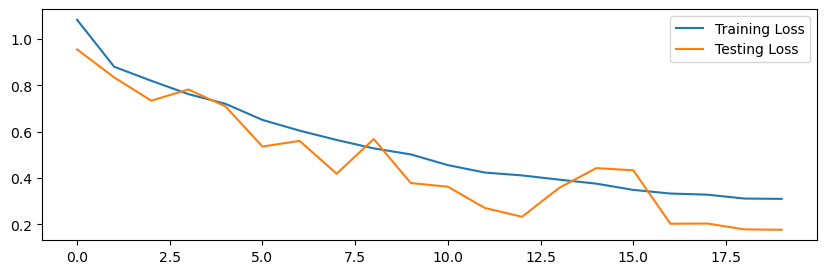

In [ ]:
plt.figure(figsize=(10,3))
plt.plot(trainingLoss, label='Training Loss')
plt.plot(testingLoss, label='Testing Loss')
plt.legend()

## Obtaining validation data

In [ ]:
labelsvalidation, validation = getData('/kaggle/input/augmented-alzheimer-mri-dataset/OriginalDataset')

## Validation set preprocessing function
Since the original dataset is already in grayscale, we define a new preprocess function without the rgb2gray

In [ ]:
def preprocessValidation(imagePath, label):
    image = tfio.read_file(imagePath)
    image = tfio.decode_image(image)
    layer = tf.keras.layers.CenterCrop(180, 180)
    image=layer(image) / 255.0
    return image, label

In [ ]:
datavalidation = datasetConfiguration(validation, preprocessValidation)

# Validation accuracy

In [ ]:
model9.evaluate(datavalidation)

400/400 [==============================] - 3s 7ms/step - loss: 0.3748 - sparse_categorical_accuracy: 0.8441


[0.3747608959674835, 0.8440625071525574]

## Prediction of several values

In [ ]:
labelsOrdernp = np.array(labelsOrder)

In [ ]:
predictData = datavalidation.as_numpy_iterator().next()

In [ ]:
y = model9.predict(predictData[0])

1/1 [==============================] - 0s 33ms/step


In [ ]:
df = pd.DataFrame({"Prediction": labelsOrdernp[np.argmax(y, axis=1)],
                   "True Label": labelsOrdernp[predictData[1]]})
df

,Prediction,True Label
0,MildDemented,MildDemented
1,NonDemented,NonDemented
2,NonDemented,NonDemented
3,VeryMildDemented,VeryMildDemented
4,VeryMildDemented,NonDemented
5,NonDemented,NonDemented
6,MildDemented,MildDemented
7,VeryMildDemented,NonDemented
8,VeryMildDemented,VeryMildDemented
9,NonDemented,NonDemented
